In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[76]:


import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_excel("data_main.xlsx")
print(df.head())


# It took a few monutes to load the data, so I keep a copy as a backup.

# In[224]:


df1 = df


# We need to do santity check about the data

# In[225]:


df1.TRANS_ID.nunique()
#df1.CARD_HOLDER.nunique()


# In[188]:


#df1.CARD_HOLDER.unique()


# In[189]:


#customer_country=df1[['BRANCH','CARD_HOLDER']].drop_duplicates()

#customer_country.groupby(['BRANCH'])['CARD_HOLDER'].aggregate('count').reset_index().sort_values('CARD_HOLDER', ascending=False)


# More than 90% of the customers in the data are from United Kingdom, There’s some research indicating that customer clusters vary by geography, so here I’ll restrict the data to United Kingdom only.

# In[226]:


#df1 = df1.loc[df1['Country'] == 'United Kingdom']


# Check whether there are missing values in each column.
# 
# There are 133600 missing values in CustomerID column, since our analysis is based on customers, we will remove these missing values.

# In[227]:


df1.isnull().sum(axis=0)


# In[228]:


#df1 = df1[pd.notnull(df1['CustomerID'])]
#df1.isnull().sum(axis=0)


# Check the min and max values in Unit price column

# In[229]:


df1.describe()


# In[230]:


#df1.Quantity.min()


# Remove the negative values in Quantity column

# In[231]:


#df1 = df1[(df1['Quantity']>0)]
#df1.Quantity.min()


# After cleaning up, we now dealing with 354345 rows and 8 columns

# In[232]:


#df1.shape


# In[233]:


#df1.info()


# Check unique value for each column

# In[234]:

'''
def unique_counts(df1):
   for i in df1.columns:
       count = df1[i].nunique()
       print(i, ": ", count)
unique_counts(df1)
'''

# In[235]:


df1.head()


# Add a column for total price

# In[236]:

'''
df1['TotalPrice'] = df1['Quantity'] * df1['UnitPrice']
df1.head()
'''

# Find out first and last order date in the data

# In[237]:


df1['OP_DATE_PRECISE'].min()


# In[238]:


df1['OP_DATE_PRECISE'].max()


# Since recency is calculated for a point in time. The last invoice date is 2011-12-09, this is the date we will use to calculate recency.

# In[239]:


import datetime as dt
NOW = dt.datetime(2017,8,16)


# In[240]:


df1['OP_DATE_PRECISE'] = pd.to_datetime(df['OP_DATE_PRECISE'], format="%d/%m/%Y")


# Create a RFM table

# In[241]:


rfmTable = df1.groupby('CARD_HOLDER').agg({'OP_DATE_PRECISE': lambda x: (NOW - x.max()).days, # Recency
                                        'TRANS_ID': lambda x: x.count(),      # Frequency
                                        'AMOUNT': lambda x: x.sum()}) # Monetary Value

rfmTable['OP_DATE_PRECISE'] = rfmTable['OP_DATE_PRECISE'].astype(int)
rfmTable.rename(columns={'OP_DATE_PRECISE': 'recency', 
                         'TRANS_ID': 'frequency', 
                         'AMOUNT': 'monetary_value'}, inplace=True)


# Calculate RFM metrics for each customer

# In[242]:


rfmTable.head()


# Interpretation:
# 
# CustomerID 12346 has frequency:1, monetary value:$77183.60 and recency:324 days.
# 
# CustomerID 12747 has frequency: 103, monetary value: $4196.01 and recency: 1 day
# 
# Let's check the details of the first customer.

# In[243]:


#first_customer = df1[df1['CustomerID']== 12346.0]
#first_customer


# The first customer has shopped only once, bought one item at a huge quantity(74215). The unit price is very low, seems a clearance sale.

# In[244]:


#(NOW - dt.datetime(2011,1,18)).days==326


# The easies way to split metrics into segments is by using quartile. 
# 
# 1. This gives us a starting point for detailed analysis
# 2. 4 segments are easy to understand and explain

# In[245]:


quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles


# In[246]:


quantiles = quantiles.to_dict()
quantiles


# Create a segmented RFM table

# In[247]:


segmented_rfm = rfmTable


# Lowest recency, highest frequency and monetary are our best customers 

# In[248]:


def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


# In[249]:


segmented_rfm['r_quartile'] = segmented_rfm['recency'].apply(RScore, args=('recency',quantiles,))
segmented_rfm['f_quartile'] = segmented_rfm['frequency'].apply(FMScore, args=('frequency',quantiles,))
segmented_rfm['m_quartile'] = segmented_rfm['monetary_value'].apply(FMScore, args=('monetary_value',quantiles,))


# Add segment numbers to the RFM table

# In[250]:


segmented_rfm.head()


# RFM segments split your customer base into an imaginary 3D cube. It is hard to visualize. However, we can sort it out.
# 
# Add a new column to combine RFM score, 111 is the highest score as we determined earlier.

# In[222]:


segmented_rfm['RFMScore'] = segmented_rfm.r_quartile.map(str)\
                             + segmented_rfm.f_quartile.map(str)\
                             + segmented_rfm.m_quartile.map(str)
segmented_rfm.head()


# Apparently, the first customer is not our best customer at all.

# Here is top 10 of our best customers!

# In[218]:


segmented_rfm[segmented_rfm['RFMScore']=='111'].sort_values('monetary_value', ascending=False).head(10)
segmented_rfm[segmented_rfm['RFMScore']=='444'].sort_values('monetary_value', ascending=False).head(10)


# Learn more
# 
# [Buy ’Til You Die - A Walkthrough](https://cran.r-project.org/web/packages/BTYD/vignettes/BTYD-walkthrough.pdf)
# 
# [Customer Segmentation for a wine seller](http://blog.yhat.com/posts/customer-segmentation-using-python.html)
# 
# If you are interested in implenting RFM in R, [Kimberly Coffey](http://www.kimberlycoffey.com/blog/2016/8/k-means-clustering-for-customer-segmentation) has a [great tutorial](http://www.kimberlycoffey.com/blog/2016/8/k-means-clustering-for-customer-segmentation) on the same dataset.

# reference: [Blast Analytics and Marketing](http://www.blastam.com/blog/rfm-analysis-boosts-sales)

# In[219]:

rfm_scores = segmented_rfm.iloc[:,3:6]

# In[220]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

#normalize
normalized_rfm = rfmTable.iloc[:, 0:3]
normalized_rfm.recency = (normalized_rfm.recency - normalized_rfm.recency.mean())/normalized_rfm.recency.std()
normalized_rfm.frequency = (normalized_rfm.frequency - normalized_rfm.frequency.mean())/normalized_rfm.frequency.std()
normalized_rfm.monetary_value = (normalized_rfm.monetary_value - normalized_rfm.monetary_value.mean())/normalized_rfm.monetary_value.std()


wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(normalized_rfm)
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,11), wcss)
plt.title('Elbow graph')
plt.xlabel('Cluster number')
plt.ylabel('WCSS')
plt.show()

# In[221]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=0)
clusters = kmeans.fit_predict(normalized_rfm)

# In[222]:
rfmTable['clusters'] = clusters
rfmTable.head()

# In[]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

#ax.scatter(normalized_rfm.recency, normalized_rfm.frequency, normalized_rfm.monetary_value, s=30)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    ax.scatter(normalized_rfm.recency[rfmTable.clusters == i], normalized_rfm.frequency[rfmTable.clusters == i], normalized_rfm.monetary_value[rfmTable.clusters == i], c = colors[i])
    



   CARD_HOLDER FIRST_NAME      SURNAME     TRANS_ID  AMOUNT OP_DATE_PRECISE
1      2858395     SEYMUR    ƏLƏKBƏROV  TM750566453   187.0      09/08/2017
2      2877930      ELVİN      QASIMOV  TM750566459    30.0      09/08/2017
3      2877930      ELVİN      QASIMOV  TM750566460     1.0      09/08/2017
4      2878034      LEYLA  QİZETDİNOVA  TM750566462     2.0      09/08/2017
5      2878034      LEYLA  QİZETDİNOVA  TM750566463     2.0      09/08/2017


<Figure size 640x480 with 1 Axes>

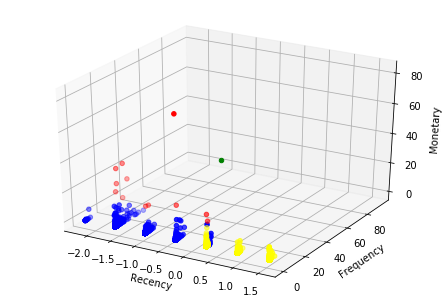

In [2]:
# In[]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(2)
ax = fig.add_subplot(111, projection='3d')
ax = Axes3D(fig)

#ax.scatter(normalized_rfm.recency, normalized_rfm.frequency, normalized_rfm.monetary_value, s=30)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

colors = ['blue', 'yellow', 'green', 'red']

for i in range(0,4):
    ax.scatter(normalized_rfm.recency[rfmTable.clusters == i], normalized_rfm.frequency[rfmTable.clusters == i], normalized_rfm.monetary_value[rfmTable.clusters == i], c = colors[i])